In [5]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

data_file = "../../Fa/refseq_combined_cds.csv.gz"
dataframe = pd.read_csv(data_file,sep="\t",compression = "gzip")

In [10]:
from bioseq2seq.bin.batcher import train_test_val_split

df_train,df_test,df_val = train_test_val_split(dataframe,1000,65)
df_val = df_val.set_index("ID")

total number = 63269


In [26]:
# %load attribution_analysis.py
import sys,random
import json
import os,re

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import pearsonr,kendalltau,ttest_ind
from collections import defaultdict
from IPython.display import Image

from Bio.Data import CodonTable
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio import SeqIO

from bioseq2seq.inputters.batcher import train_test_val_split
#from captum.attr import visualization as viz
#from interpretation import visualizer as viz

def plot_stem(name,array,labels):

    array = np.asarray(array)
    array = np.expand_dims(array,axis=1)
    array = array / np.linalg.norm(array,ord=2)

    ax = plt.stem(array,use_line_collection=True)
    #plt.show()
    #plt.savefig(name+"_stemplot.png")
    #plt.close()

def annotate_cds(start,end):

    width = 0.75
    color = "dimgray"

    plt.axvline(start,linestyle = "-.",linewidth = width,c=color)
    plt.axvline(end,linestyle = "-.",linewidth = width,c=color)

def plot_line(name,array,smoothed,cds_start=None,cds_end=None):
    
    array = array / np.linalg.norm(array)
    plt.plot(array,label="raw")
    #plt.plot(smoothed,label="smoothed")    
    plt.ylabel("Attention")
    plt.xlabel("Position")
    plt.legend()
    
    if not cds_start == None and not cds_end == None:
        annotate_cds(cds_start,cds_end)

    #plt.axhline(1/len(array),linestyle = "-.",linewidth = 0.75,c="black")
    plt.tight_layout()
    output = name+"_lineplot.pdf"
    #plt.show()
    #plt.savefig(output)
    #plt.close()

def get_top_k(array,k=15):

    k = k if k < len(array) else len(array)
    array = np.asarray(array)

    k_largest_inds = np.argpartition(array,-k)[-k:]
    k_largest_scores = array[k_largest_inds].tolist()
    k_largest_inds = k_largest_inds.tolist()

    return k_largest_scores,k_largest_inds

def get_min_k(array,k=15):

    k = k if k < len(array) else len(array)
    array = np.asarray(array)

    k_smallest_inds = np.argpartition(array,k)[:k]
    k_smallest_inds = k_smallest_inds.tolist()

    return k_smallest_inds

def top_indices(saved_file,tgt_field,coding_topk_file,noncoding_topk_file,mode= "attn"):
    
    df_storage = []
    coding_storage = []
    noncoding_storage = []

    out_name = saved_file.split(".")[0]
    
    with open(saved_file) as inFile:
        for l in inFile:
            fields = json.loads(l)
            id_field = "TSCRIPT_ID" if mode == "attn" else "ID"

            id = fields[id_field]
            array = fields[tgt_field]
            name = id + "_" + mode
            
            window_size = 50
            smoothed = np.asarray(smooth_array(array,window_size))
            scores,indexes = get_top_k(smoothed,1)
            tscript_type = "<PC>" if (id.startswith("XM_") or id.startswith("NM_")) else "<NC>"
            
            storage = (id,indexes)
            
            if tscript_type == "<PC>":
                coding_storage.append(storage)
            else:
                noncoding_storage.append(storage)

    # save top indices
    with open(coding_topk_file,'w') as outFile:
        for tscript,indices in coding_storage:
            index_str = ",".join([str(x) for x in indices])
            outFile.write("{},{}\n".format(tscript,index_str))

    with open(noncoding_topk_file,'w') as outFile:
        for tscript,indices in noncoding_storage:
            index_str = ",".join([str(x) for x in indices])
            outFile.write("{},{}\n".format(tscript,index_str))

def plot_attn_attr_corr(attn_file,attr_file):

    storage = {}
    corrs = []
    count = 0

    attn_field = "layer_0_pos_0"
    attn_prefix = attn_file.split(".")[0]
    
    print("Loading all attentions")
    with open(attn_file) as inFile:
        for l in inFile:
            fields = json.loads(l)
            #id = fields["TSCRIPT_ID"]
            #storage[id] = fields[attn_field]
            id = fields["ID"]
            storage[id] = fields["attr"]

    print("Loading all attributions")
    with open(attr_file) as inFile:
        for l in inFile:
            fields = json.loads(l)
            
            id = fields["ID"]
            attr = fields["attr"]
            
            if id in storage: # and (id.startswith("XM_") or id.startswith("NM_")):
                count +=1
                attn = storage[id]
                print(" ID: {} , len(attr) {} , len(attn) {}".format(id,len(attr),len(attn)))

                if len(attr) < len(attn):
                    attn = attn[:len(attr)]
                elif len(attn) < len(attr):
                    attr = attr[:len(attn)]

                correlation = kendalltau(attr,attn)                
                corrs.append(correlation[0])

    mu = np.mean(corrs)
    median = np.median(corrs)
    sigma = np.std(corrs)

    textstr = '\n'.join((
    r'$\mu=%.3f$' % (mu, ),
    r'$\mathrm{median}=%.3f$' % (median, ),
    r'$\sigma=%.3f$' % (sigma, )))

    ax = sns.distplot(corrs)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    ax.set(xlabel="Kendall tau", ylabel='Density')

    plt.figure()
    plt.title("Enc-Dec vs normed")
    corr_plot = attn_prefix +"_normed_kendall_corrs.pdf"
    #plt.show()
    #plt.savefig(corr_plot)
    #plt.close()

def smooth_array(array,window_size):

    half_size = window_size // 2
    running_sum = sum(array[:half_size]) 
    
    smoothed_scores = [0.0]*len(array)

    trail_idx = 0
    lead_idx = half_size

    for i in range(len(array)):
        gap_size = lead_idx - trail_idx + 1
        smoothed_scores[i] = running_sum / gap_size

        # advance lead until it reaches end
        if lead_idx < len(array)-1:
            running_sum += array[lead_idx]
            lead_idx +=1

        # advance trail when the gap is big enough or the lead has reached the end        
        if gap_size == window_size or lead_idx == len(array) -1:
            running_sum -= array[trail_idx]
            trail_idx+=1
        
    return smoothed_scores
        
def top_k_to_substrings(top_k_csv,df):
    
    storage = []
    sequences = []
    
    # ingest top k indexes from attribution/attention
    with open(top_k_csv) as inFile:
        for l in inFile:
            fields = l.rstrip().split(",")
            id = fields[0]
            seq = df.loc[id,'RNA']

            substrings = []
            left_bound = 24
            right_bound = 25
            
            # get window around indexes
            for num,idx in enumerate(fields[1:]):
                idx = int(idx)
                start = idx-left_bound if idx-left_bound > 0 else 0
                end = idx+right_bound+1 if idx+right_bound+1 < len(seq) -1 else len(seq) -1

                substr = seq[start:end]
                substrings.append(substr)
                
                if len(substr) > 7:
                    description = "loc[{}:{}]".format(start+1,end+1)
                    record = SeqRecord(Seq(substr),
                                            id=id+"_"+str(num),
                                            description=description)
                    sequences.append(record)

            entry = [id]+ substrings
            storage.append(entry)

    top_kmer_file = top_k_csv.split(".")[0] +"_subseq.csv"
    top_kmer_fasta = top_k_csv.split(".")[0] +"_motifs.fasta" 
    print("Writing to",top_kmer_fasta)
    
    # write output
    with open(top_kmer_file,'w') as outFile:
        for s in storage:
            outFile.write(",".join(s)+"\n")
    
    with open(top_kmer_fasta,'w') as outFile:
        #SeqIO.write(random.sample(sequences,500), outFile, "fasta")
        SeqIO.write(sequences, outFile, "fasta")

def keep_nonzero(array):
    nonzero = []
    for a in array:
        f = float(a)
        if f == 0.0:
            break
        else:
            nonzero.append(f)
    return nonzero

def getLongestORF(mRNA):
    ORF_start = -1
    ORF_end = -1
    longestORF = 0
    for startMatch in re.finditer('ATG',mRNA):
        remaining = mRNA[startMatch.start():]
        if re.search('TGA|TAG|TAA',remaining):
            for stopMatch in re.finditer('TGA|TAG|TAA',remaining):
                ORF = remaining[0:stopMatch.end()]
                if len(ORF) % 3 == 0:
                    if len(ORF) > longestORF:
                        ORF_start = startMatch.start()
                        ORF_end = stopMatch.end()
                        longestORF = len(ORF)
                    break
    return ORF_start,ORF_end

def make_chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def codon_scores(saved_file,df,tgt_field,boxplot_file,significance_file,mode="attn"):

    extra = []
    
    with open(saved_file) as inFile:
        for l in inFile:
            
            fields = json.loads(l)
            id_field = "TSCRIPT_ID" if mode == "attn" else "ID"

            id = fields[id_field]
            array = fields[tgt_field]
            seq = df.loc[id,'RNA']
            tscript_type = df.loc[id,'Type']

            if tscript_type == "<PC>":               
                # use provided CDS
                cds = df.loc[id,'CDS']
                if cds != "-1":
                    splits = cds.split(":")
                    clean = lambda x : x[1:] if x.startswith("<") or x.startswith(">") else x
                    cds_start,cds_end = tuple([int(clean(x)) for x in splits])
                else:
                    cds_start,cds_end = getLongestORF(seq)
            else:
                # use start and end of longest ORF
                cds_start,cds_end = getLongestORF(seq)
            
            if len(seq) != len(array):
                array = [float(x) for x in array[:len(seq)]]

            uniform = 3/len(array)

            inside = defaultdict(lambda : [0.0])
            outside = defaultdict(lambda : [0.0])

            disallowed = {'N','K','R','Y'}
            allowed = lambda codon : all([x not in disallowed for x in codon])
            inframe = lambda x : x >= cds_start and x<=cds_end-2 and (x-cds_start) % 3 == 0 

            # 5' UTR and out of frame and 3' UTR
            for i in range(0,len(array)-3):
                codon = seq[i:i+3]
                if allowed(codon) and not inframe(i):
                    score = sum(array[i:i+3])
                    outside[codon].append(score)
            for codon,scores in outside.items():
                avg = sum(scores) / len(scores) 
                info = {"tscript" : id ,"codon" : codon, "score" : avg/uniform, "status" : tscript_type, "segment" : "OUT"}
                extra.append(info)

            # CDS
            for i in range(cds_start,cds_end-3,3):
                codon = seq[i:i+3]
                if allowed(codon):
                    score = sum(array[i:i+3])
                    inside[codon].append(score)
            for codon,scores in inside.items():
                avg = sum(scores) / len(scores)
                info = {"tscript" : id ,"codon" : codon, "score" : avg/uniform, "status" : tscript_type, "segment" : 'CDS'}
                extra.append(info)
            
        codon_df = pd.DataFrame(extra)
        num_coding = num_noncoding = num_out_coding = num_cds_coding = num_cds_noncoding = num_out_noncoding = 0

        cds_ratios = defaultdict(float)
        coding_status_ratios = defaultdict(float)

        with open(significance_file,'w') as outFile:
            for codon in codon_df.codon.unique():
                
                # compare coding and noncoding
                coding = codon_df[(codon_df.codon == codon) & (codon_df.status == "<PC>")]
                noncoding = codon_df[(codon_df.codon == codon) & (codon_df.status == "<NC>")]
                
                result = ttest_ind(coding.score,noncoding.score,equal_var=False)
                # count number of significant differences
                if result.pvalue < 0.01:
                    pc_score = coding.score.mean()
                    nc_score = noncoding.score.mean()
                    ratio = 0
                    if pc_score > nc_score:
                        num_coding+=1
                        ratio = pc_score / nc_score 
                    elif pc_score < nc_score:
                        num_noncoding+=1
                        ratio = nc_score / pc_score

                    coding_status_ratios[codon] = ratio
                
                # compare CDS vs UTR
                out = coding[coding.segment == "OUT"]
                cds = coding[coding.segment == "CDS"]

                result = ttest_ind(out.score,cds.score,equal_var=False)
                # count number of significant differences
                if result.pvalue < 0.01:
                    out_score = out.score.mean()
                    cds_score = cds.score.mean()
                    ratio = 0 
                    if cds_score > out_score:
                        num_cds_coding+=1
                        ratio = cds_score / out_score
                    elif cds_score < out_score:
                        num_out_coding+=1
                        ratio = out_score / cds_score
                    
                    cds_ratios[codon] = ratio 

                # compare CDS vs UTR
                out = noncoding[noncoding.segment == "OUT"]
                cds = noncoding[noncoding.segment == "CDS"]

                result = ttest_ind(out.score,cds.score,equal_var=False)
                # count number of significant differences
                if result.pvalue < 0.01:
                    out_score = out.score.mean()
                    cds_score = cds.score.mean()
                    if cds_score > out_score:
                        num_cds_noncoding+=1
                    elif cds_score < out_score:
                        num_out_noncoding+=1

            outFile.write("Overall : {}/64 higher in coding , {}/64 higher in noncoding\n".format(num_coding,num_noncoding))
            outFile.write("Coding : {}/64 higher in CDS, {}/64 higher outside\n".format(num_cds_coding,num_out_coding))
            outFile.write("Noncoding: {}/64 higher in CDS, {}/64 higher outside\n".format(num_cds_noncoding,num_out_noncoding))

        eps = 1e-12
        sorted_ratios = {k: v for k, v in sorted(cds_ratios.items(), key=lambda item: item[1],reverse=True)}

        plt.figure(figsize=(20,5))
        coding = codon_df[codon_df.status == "<PC>"]
        
        for codon in sorted_ratios.keys():
            data = coding[coding.codon == codon]
            ax = sns.boxplot(y="codon",x="score",hue="segment",data=data,showfliers=False,whis=[5, 95])
            plt.title("Enrichment in CDS")
            plt.tight_layout(rect=[0,0.03,1,0.95])

def run_attributions(saved_file,df_val,tgt_field,best_dir,mode="attn"):

    prefix = best_dir+"/"+tgt_field+"results/"

    if not os.path.isdir(prefix):
        os.mkdir(prefix)

    # results files
    coding_indices_file = prefix+"coding_topk_idx.txt"
    noncoding_indices_file = prefix+"noncoding_topk_idx.txt"
    boxplot_file = prefix+"coding_boxplot.pdf"
    significance_file = prefix+"significance.txt"
    hist_file = prefix+"pos_hist.pdf"

    #top_indices(saved_file,tgt_field,coding_indices_file,noncoding_indices_file,mode=mode)
    #top_k_to_substrings(coding_indices_file,df_val)
    #top_k_to_substrings(noncoding_indices_file,df_val)
    codon_scores(saved_file,df_val,tgt_field,boxplot_file,significance_file,mode)
    get_positional_bias(saved_file,df_val,tgt_field,hist_file,mode)
    
    if not mode == "attr":
        #plot_attn_attr_corr(saved_file,attr_file)
        pass

def get_positional_bias(saved_file,df,tgt_field,hist_file,mode):
    
    storage = []
    temp_idx = 0

    with open(saved_file) as inFile:
        for l in inFile:
            fields = json.loads(l)
            id_field = "TSCRIPT_ID" if mode == "attn" else "ID"

            id = fields[id_field]
            array = fields[tgt_field]
            seq = df.loc[id,'RNA']
            tscript_type = df.loc[id,'Type']

            argmax = np.argmax(array)

            if tscript_type == "<PC>":               
                # use provided CDS
                cds = df.loc[id,'CDS']
                if cds != "-1":
                    splits = cds.split(":")
                    clean = lambda x : x[1:] if x.startswith("<") or x.startswith(">") else x
                    cds_start,cds_end = tuple([int(clean(x)) for x in splits])
                else:
                    cds_start,cds_end = getLongestORF(seq)

                entry = {"status" : "coding", "distance" : argmax-cds_start}
                storage.append(entry)
            else:
                # use start and end of longest ORF
                cds_start,cds_end = getLongestORF(seq)
                entry = {"status" : "noncoding", "distance" : argmax-cds_start}
                storage.append(entry)

    plt.figure()
    df = pd.DataFrame(storage)
    sns.histplot(df,x="distance",kde=False,hue="status",stat="density")
    
    plt.xlabel("Position relative to start/first AUG")
    plt.ylabel("Density")
    plt.title("Position of maximum attention")
    plt.tight_layout(rect=[0,0.03,1,0.95])
    #plt.savefig(hist_file)
    #plt.show()
    #plt.close()

def visualize_attribution(data_file,attr_file):

    # ingest stored data
    dataframe = pd.read_csv(data_file,sep="\t",compression = "gzip")
    df_train,df_test,df_val = train_test_val_split(dataframe,1000,65)
    df_val = df_val.set_index("ID")

    print("Loading all attributions")
    with open(attr_file) as inFile:
        idx = 0
        for l in inFile:
            fields = json.loads(l)
            #id = fields["TSCRIPT_ID"]
            id = fields["ID"]
            #attr = np.asarray([float(x) for x in fields["layer_0_pos_0"]]) 
            attr = np.asarray([float(x) for x in fields["attr"]])
            seq = df_val.loc[id,"RNA"]
            # storing couple samples in an array for visualization purposes
            vis = viz.VisualizationDataRecord(
                                    attr,
                                    0.90,
                                    25,
                                    25,
                                    25,
                                    attr.sum(),
                                    seq,
                                    100)

            display = viz.visualize_text([vis])

            with open(id+"_IG_viz.html",'w') as outFile:
                outFile.write(display.data)
            if idx == 9:
                break
            idx+=1
'''
if __name__ == "__main__":
    
    plt.style.use('ggplot')
    
    # ingest stored data
    data_file = "../Fa/refseq_combined_cds.csv.gz"
    dataframe = pd.read_csv(data_file,sep="\t",compression = "gzip")
    df_train,df_test,df_val = train_test_val_split(dataframe,1000,65)
    df_val = df_val.set_index("ID")
    
    for l in range(4):
        layer = "results/best_ED_classify/best_ED_classify_layer"+str(l)+".enc_dec_attns"
        for h in range(8):
            tgt_head = "layer{}head{}".format(l,h)
            print("tgt_head: ",tgt_head)
            run_attributions(layer,df_val,tgt_head,"results/best_ED_classify","attn")
    
    for l in range(4):
        layer = "best_seq2seq/best_seq2seq_layer"+str(l)+".enc_dec_attns"
        for h in range(8):
            tgt_head = "layer{}head{}".format(l,h)
            print("tgt_head: ",tgt_head)
            run_attributions(layer,df_val,tgt_head,"../results/best_seq2seq","attn")
'''


In [27]:
%matplotlib inline

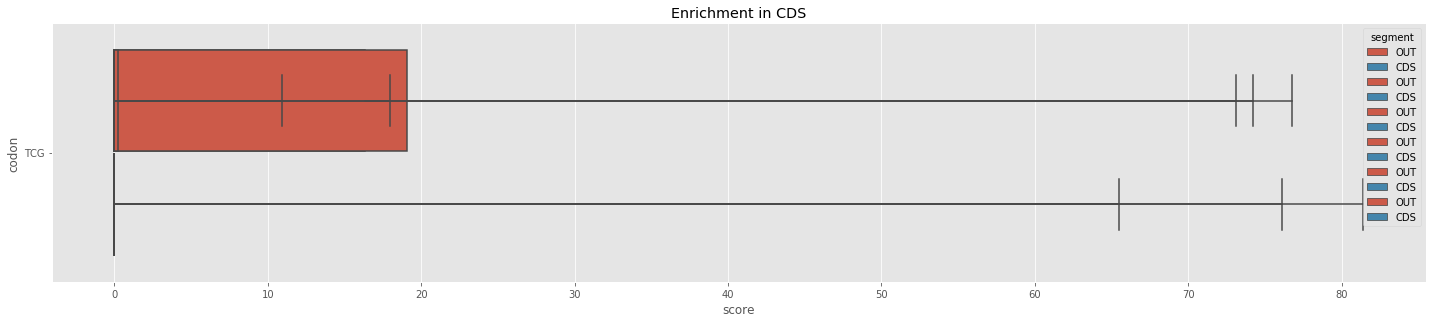

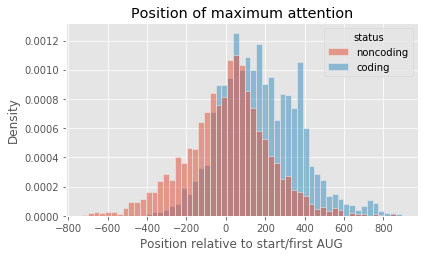

In [28]:
for l in range(1):
    parent = "../results/best_ED_classify"
    layer = parent+"/best_ED_classify_layer"+str(l)+".enc_dec_attns"
    for h in range(1):
        tgt_head = "layer{}head{}".format(l,h)
        run_attributions(layer,df_val,tgt_head,parent,"attn")

In [23]:
plt.show()